In [ ]:
!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y
!pip install pydicom

In [1]:
import sys , json, glob, random, re, math
import collections, time, zipfile, cv2
from types import SimpleNamespace

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm

2024-04-04 10:24:06.908344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 10:24:06.908498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 10:24:07.103286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Configuration Setup**

In [2]:
dir_conf = SimpleNamespace(
    data_directory = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification',
    train_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train',
    test_dir = '/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/test',
    train_labels_path = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv",
)


train_conf = SimpleNamespace(
    IMAGE_SIZE = 128,
    DEPTH_CHANENLS = 64,
    EPOCHS=5,
    BATCH_SIZE=4,
)

In [3]:
def load_dicom_image(path, img_size=train_conf.IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data

<font size="+1">

### **Returns a single 3D image**

For each directory, images at the beginning contains no information while images at the end seems to contain repetative information.  <br>
We started selecting images from the middle of the opeartion for higher clarity and data preservation.
    <br><br>
    
    
    
**How depth channel consistency maintained:**
    
If any 3D image have less than expected depth, we started adding some images from the center to the 0 index. <br>
If not enough depth yet, apply 0 padding.

In [4]:
def load_dicom_images_3d(scan_id, depth_chnls=train_conf.DEPTH_CHANENLS, img_size=train_conf.IMAGE_SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{dir_conf.data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
    
    middle = len(files)//2
    num_imgs2 = depth_chnls//2
    pick_start_idx = max(0, middle - num_imgs2)
    pick_end_idx = min(len(files), middle + num_imgs2)
    
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[pick_start_idx:pick_end_idx]]).T  # The way np.stack works, shape before transpose is (64, 128, 128). We want depth channel to be 3rd channel.
    
    
    if img3d.shape[-1] < depth_chnls:
        n_zero = np.zeros((img_size, img_size, depth_chnls - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

In [5]:
def draw_pictures(image, r, c):
    image = image[0]
    fig ,axs = plt.subplots(r,c, figsize=(r*4,c*4)) # 4 by 4 for each image is good enough
    for i in range(r):
        for j in range(c):
            access_idx = i * j
            ax = axs[i, j]
            ax.imshow(image[:, :, access_idx], cmap="gray")
            ax.axis("off")

    plt.tight_layout()

(1, 128, 128, 64)
0.0 1.0 0.05 0.0
Dimension of the CT scan is: (1, 128, 128, 64)


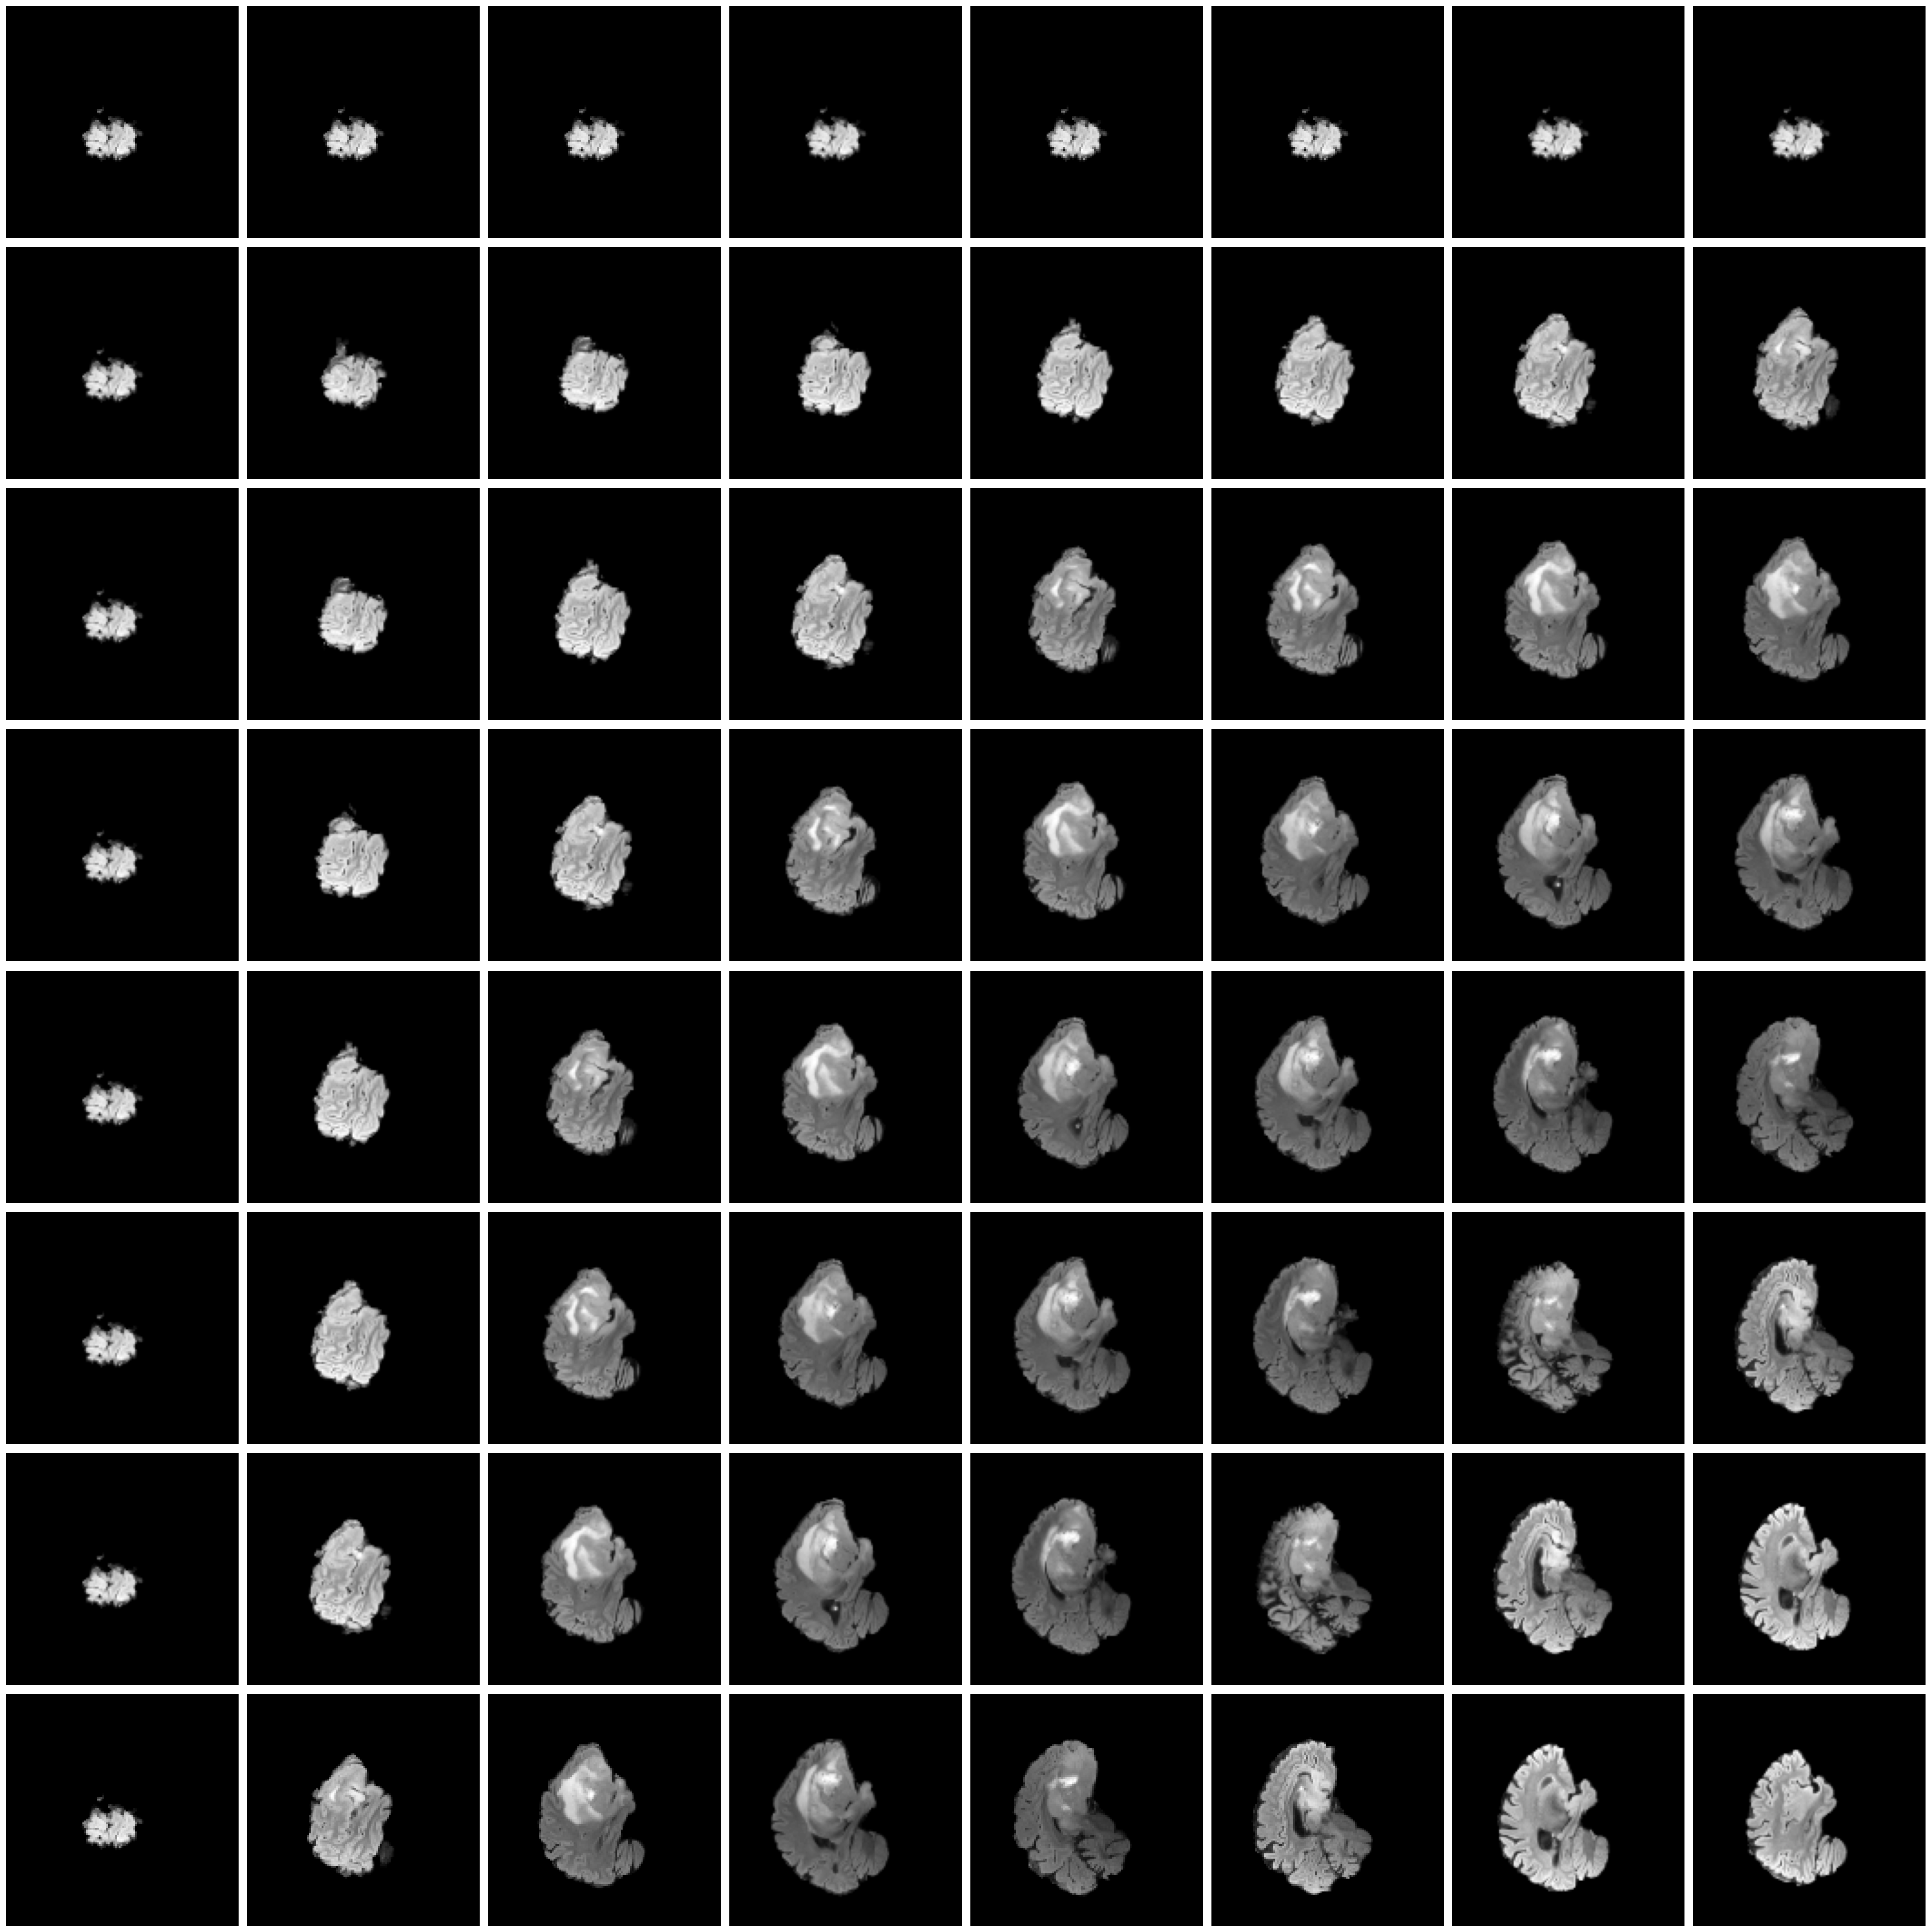

In [7]:
image = load_dicom_images_3d("00002")
print(image.shape)
print(np.min(image), np.max(image), round(np.mean(image), 2), round(np.median(image), 2))
print("Dimension of the CT scan is:", image.shape)

draw_pictures(image, r=8, c = 8)

# **1. Loading and Data Preperation**

In [82]:
class DataLoader:
    def __init__(self, mri_type, split_size):
        # Loading CSV file
        train_csv = pd.read_csv(dir_conf.train_labels_path)
        self.train_csv = self.dfIdtoFname(train_csv)
        self.mri_type = mri_type
        self.split_size = split_size
        
    
    """
        CSV file have name as 2 for filename 00002
    """
    def idchanger(self, data_point):
        fnsize = 5
        nzc = fnsize - len(str(data_point))
        nz = nzc*"0"
        return nz + str(data_point)

    def dfIdtoFname(self, df):
        col_name = "BraTS21ID"
        df[col_name] = df[col_name].apply(self.idchanger)
        return df
    
    
    def __load__(self, load_lim=150):
        loaded_img3d = [load_dicom_images_3d(fldname, mri_type=self.mri_type).T for fldname in tqdm(self.train_csv['BraTS21ID'][:load_lim])]
        labels = [lval for lval in self.train_csv['MGMT_value'][:load_lim]]
        
        print(labels)
        
        train_size, val_size, test_size = [int(s * load_lim) for s in self.split_size]
        print(f"train: {train_size}\validation: {val_size}\ttest: {test_size}")
        self.train_data = tf.data.Dataset.from_tensor_slices((loaded_img3d, labels)).take(train_size)
        self.val_data = tf.data.Dataset.from_tensor_slices((loaded_img3d, labels)).skip(train_size).take(val_size)
        self.test_data = tf.data.Dataset.from_tensor_slices((loaded_img3d, labels)).skip(train_size + val_size).take(test_size)

        print("Data Loaded")

In [ ]:
flair_dataloader = DataLoader(mri_type="FLAIR", split_size=[0.7, .2, .1])
flair_dataloader.__load__(215)


# **2. Build Model**

In [79]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((depth,width, height,1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn-ctscan")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn-ctscan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 128, 128,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 62, 126, 126,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 31, 63, 63, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 31, 63, 63, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 29, 61, 61, 64) │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 14, 30, 30, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 30, 30, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 12, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 6, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 4, 12, 12, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 2, 6, 6, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 6, 6, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,352,897 (5.16 MB)

 Trainable params: 1,351,873 (5.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [80]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "flair_classification.keras", save_best_only=True
)

In [81]:
model.fit(
    flair_dataloader.train_data.batch(train_conf.BATCH_SIZE),
    validation_data = flair_dataloader.val_data.batch(train_conf.BATCH_SIZE),
    epochs=train_conf.EPOCHS,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb],
)

AttributeError: 'DataLoader' object has no attribute 'train_data'

In [54]:
#picking last image.

sample_data = None
for i in flair_dataloader.test_data:
    sample_data = i

In [64]:
model(np.expand_dims(sample_data[0], 0))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5647102]], dtype=float32)>

In [65]:
sample_data[1]

<tf.Tensor: shape=(), dtype=int32, numpy=1>